# Import dependencies

In [1]:
!pip install dgl
!pip install torch_geometric 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 28.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.7 MB/s eta 0:00:0000:01


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plot
import dgl
from dgl.nn import GraphConv
import networkx as ntx
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
import time

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Data Preparation 

In [3]:
df=pd.read_csv("/kaggle/input/data-prm/df_final.csv")

In [4]:
df=df.drop('Unnamed: 0',axis=1)

In [5]:
df['Reference']=df['Reference'].fillna('')
df['Concept_of_type_relation']=df['Concept_of_type_relation'].fillna('')
df['Type_relation']=df['Type_relation'].fillna('')

In [6]:
triplets = []
additional_relationships = {
    'Synonym': 'is_synonym_of',
    'Reference': 'is_referenced_in',
    'Descriptions': 'has_description',
    'Definition': 'has_definition',
}

# Extract the initial triplets
for key, row in df.iterrows():
    subject = row['Concepts']
    relation = row['Type_relation']
    obj = row['Concept_of_type_relation']
    triplets.append((subject, relation, obj))
    for col, relation in additional_relationships.items():
        value = row[col]
        #if value:
        subject = row['Concepts']
        triplets.append((subject, relation, value))

In [7]:
triplets_df = pd.DataFrame(triplets, columns=['Subject', 'Relationship', 'Object'])


In [8]:
triplets_df=triplets_df.drop_duplicates()

# Construct the Graph:

In [9]:
graph = ntx.from_pandas_edgelist(triplets_df[triplets_df['Subject']=="11.5 plan risk responses"], "Subject", "Object",
                         edge_attr=True, create_using=ntx.MultiDiGraph())

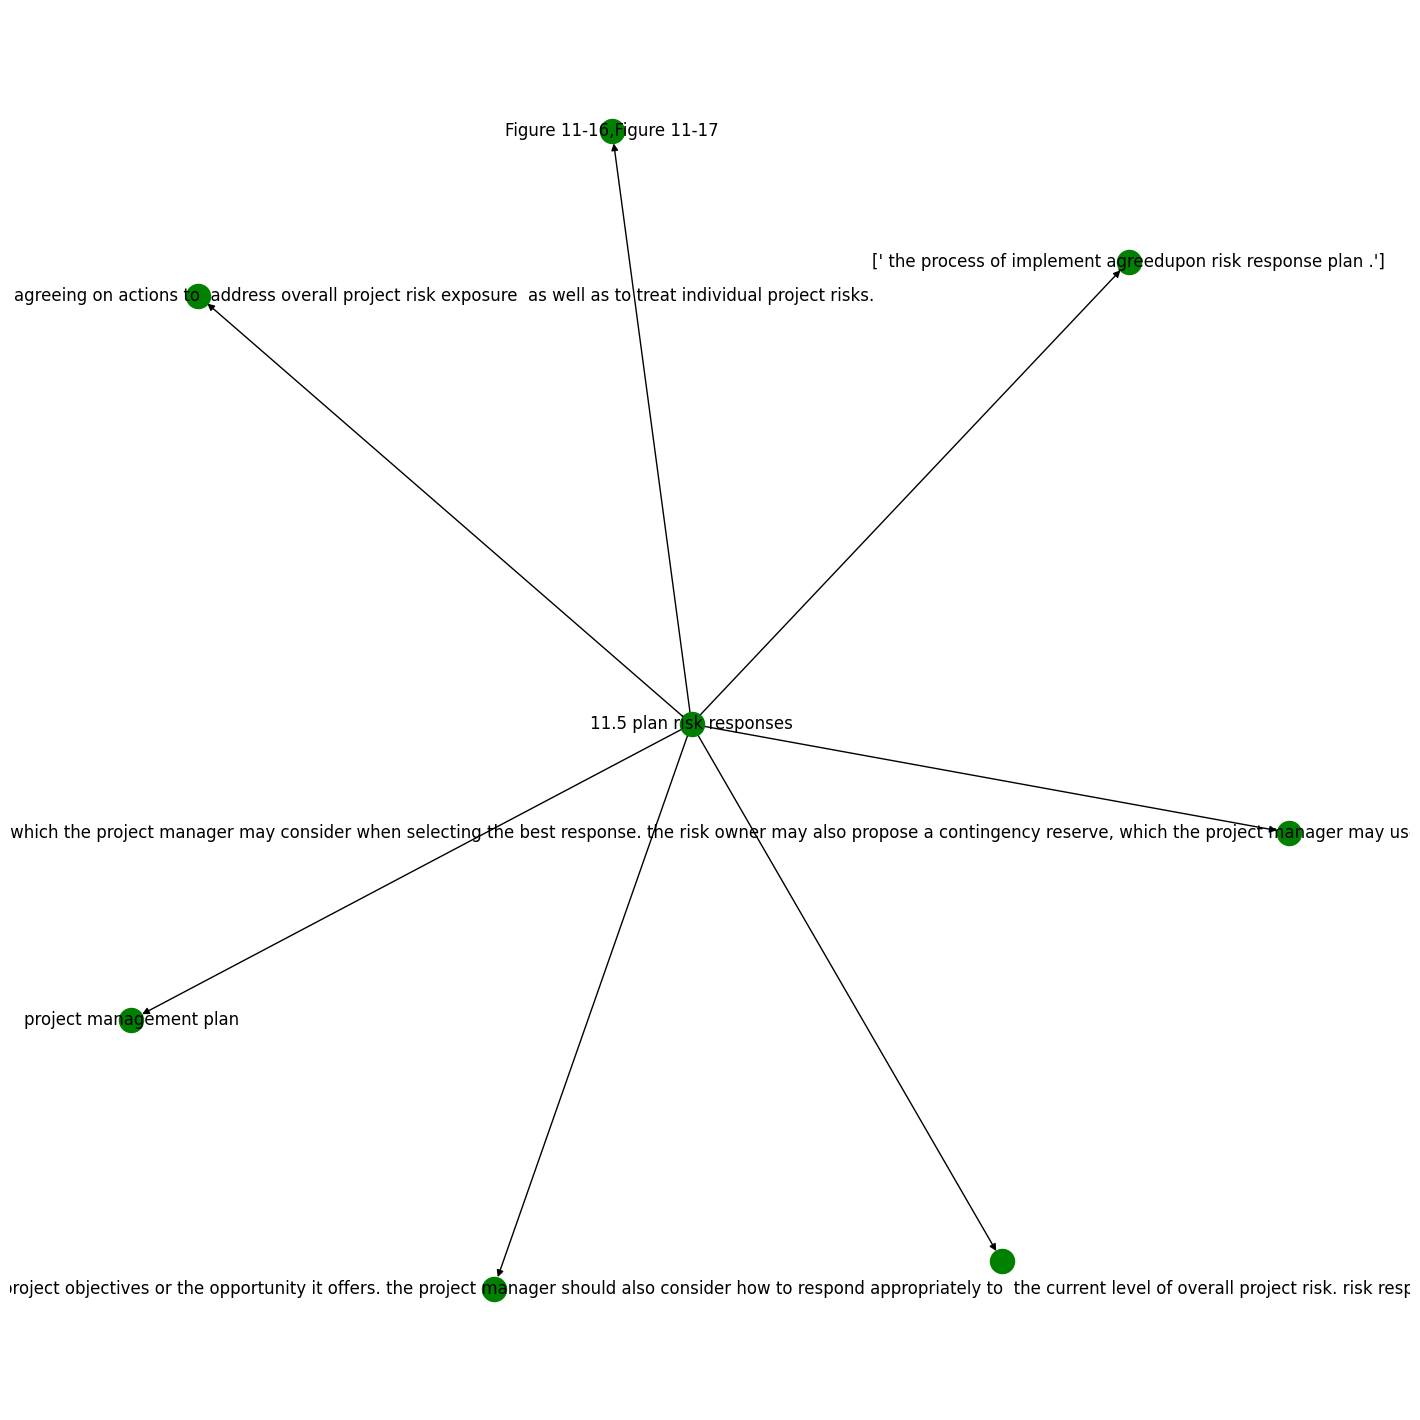

In [10]:
# plotting the network
plot.figure(figsize=(14, 14))
posn = ntx.spring_layout(graph)
ntx.draw(graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

In [11]:
data = from_networkx(graph)

In [12]:
nodes_list = list(graph.nodes())

In [13]:
u_sampel=data.edge_index[0].tolist()

In [14]:
v_sampel=data.edge_index[1].tolist()

In [15]:
u=u_sampel
v=v_sampel
g=dgl.graph((u, v))

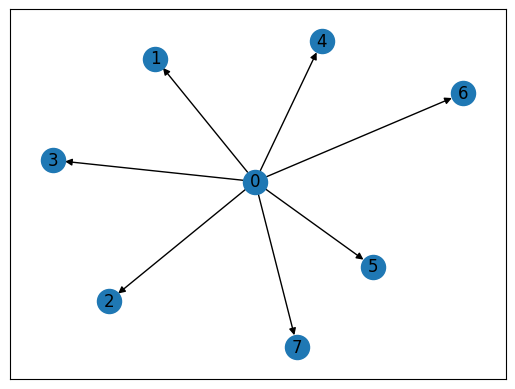

In [16]:
# draw plot using networkx
G=dgl.to_networkx(g)
ntx.draw_networkx(G)

In [17]:
triplets_df[triplets_df['Subject']=="11.5 plan risk responses"]

,Subject,Relationship,Object
20,11.5 plan risk responses,facet of,project management plan
21,11.5 plan risk responses,is_synonym_of,[' the process of implement agreedupon risk re...
22,11.5 plan risk responses,is_referenced_in,
23,11.5 plan risk responses,has_description,the process of developing options selecting s...
24,11.5 plan risk responses,has_definition,the risk responses concept defines the general...
347,11.5 plan risk responses,is_referenced_in,"Figure 11-16,Figure 11-17"
348,11.5 plan risk responses,has_description,plan risk responses is the process of developi...


In [18]:
all_graph = ntx.from_pandas_edgelist(triplets_df, "Subject", "Object",
                         edge_attr=True, create_using=ntx.MultiDiGraph())

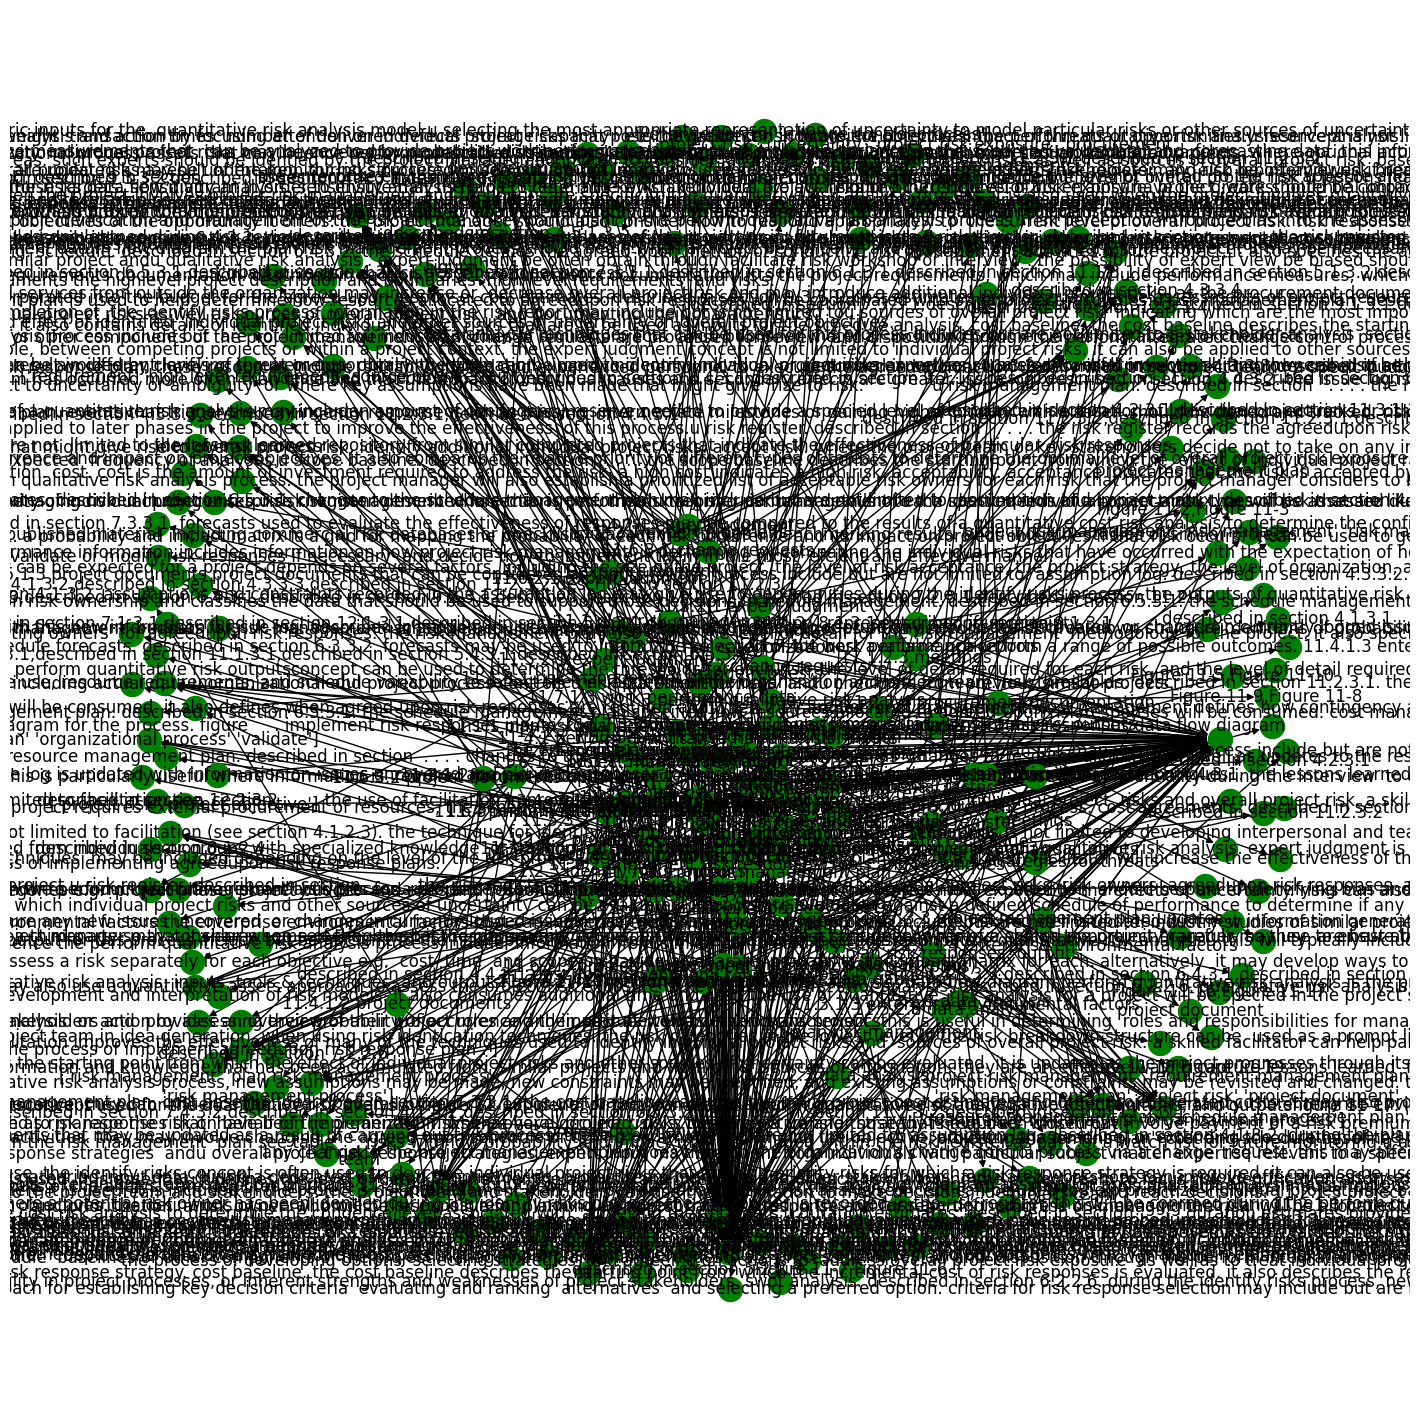

In [19]:
# plotting the network
plot.figure(figsize=(14, 14))
posn = ntx.spring_layout(all_graph)
ntx.draw(all_graph, with_labels=True, node_color='green', edge_cmap=plot.cm.Blues, pos = posn)
plot.show()

In [20]:
all_data = from_networkx(all_graph)

In [21]:
concept_indice_list=set(all_data.edge_index[0].tolist())

In [22]:
l=333*[0]

In [23]:
for indice in concept_indice_list:
    l[indice]=1

In [24]:
object_indice_list=set(all_data.edge_index[1].tolist())

In [25]:
len(object_indice_list)

222

In [26]:
for indice in object_indice_list:
        l[indice]=0

In [27]:
labels=l
labels=torch.tensor(labels)

In [28]:
u=all_data.edge_index[0].tolist()
v=all_data.edge_index[1].tolist()

In [29]:
all_g=dgl.graph((u, v))

In [30]:
all_g

Graph(num_nodes=333, num_edges=569,
      ndata_schemes={}
      edata_schemes={})

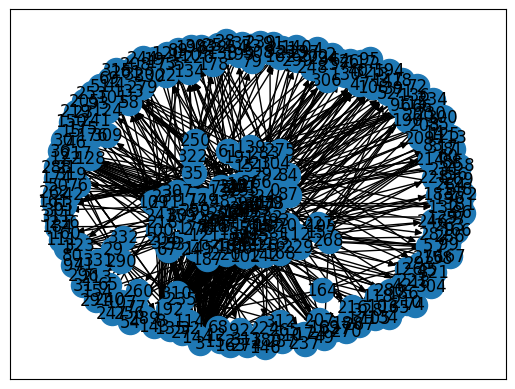

In [31]:
G=dgl.to_networkx(all_g)
ntx.draw_networkx(G)

# Node and Edge Embeddings:

In [32]:
# Assuming you have a list of strings in 'concept' column
sentences = [str(x) for x in list(all_graph.nodes())]
tokenized_concepts=[word_tokenize(sentence) for sentence in sentences]
# Train Word2Vec model
model = Word2Vec(tokenized_concepts, vector_size=128, window=5, min_count=1, sg=0)
model.save("word2vec.model")

In [33]:
# Load pre-trained word2vec model
word2vec_model = Word2Vec.load("/kaggle/working/word2vec.model")

def generate_text_embeddings(nodes, word2vec_model):
    text_embeddings_dict = {}
   
    for node in nodes:
        words = str(node).split()  # Assuming node is a string of words
        embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        if embeddings:
            # Take the mean of word embeddings for the node
            text_embeddings_dict[node] = np.mean(embeddings, axis=0)
        else:
            # If no valid word embeddings are found, use a default value (zeros in this case)
            text_embeddings_dict[node] = np.zeros(word2vec_model.vector_size)

    return text_embeddings_dict

# Get a list of nodes from your graph
nodes_list = list(all_graph.nodes())

# Generate text embeddings
text_embeddings_dict = generate_text_embeddings(nodes_list, word2vec_model)

# Now, create a list of embeddings in the same order as your nodes
node_embeddings = [text_embeddings_dict[node] for node in nodes_list]

# Convert the list of embeddings to a torch tensor
node_embeddings = torch.tensor(node_embeddings)
node_embeddings=node_embeddings.to(torch.float32)

/tmp/ipykernel_32/3205608889.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  node_embeddings = torch.tensor(node_embeddings)


In [34]:
all_g.ndata['feat']=node_embeddings

In [35]:
node_embeddings

tensor([[ 0.2037, -0.5480,  0.3489,  ...,  0.0418, -0.0812, -0.0990],
        [ 0.3021, -0.8175,  0.5225,  ...,  0.0680, -0.1259, -0.1398],
        [ 0.2518, -0.6737,  0.4274,  ...,  0.0544, -0.1036, -0.1154],
        ...,
        [ 0.2589, -0.6999,  0.4431,  ...,  0.0494, -0.0989, -0.1243],
        [ 0.2393, -0.6393,  0.4090,  ...,  0.0424, -0.0964, -0.1133],
        [ 0.2049, -0.5505,  0.3513,  ...,  0.0411, -0.0836, -0.0998]])

In [36]:
# Assuming data.Relationship contains class labels as strings
unique_labels = list(set(all_data.Relationship))

# Map labels to numerical IDs
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}

# Assign labels to nodes
labels_Edges=torch.tensor([label_to_id[label] for label in triplets_df.Relationship])

# Splitting Data

In [37]:
# assign number of labels
num_classes=9
#labels=torch.randint(0, 9, (333,))

print(all_g)

Graph(num_nodes=333, num_edges=569,
      ndata_schemes={'feat': Scheme(shape=(128,), dtype=torch.float32)}
      edata_schemes={})


In [38]:
len(labels)

333

In [39]:
num_nodes = 333

# Define the size of each split
num_train = int(0.8 * num_nodes)
num_valid = int(0.1 * num_nodes)
num_test = num_nodes - num_train - num_valid

# Generate random indices for train, valid, and test splits
indices = torch.randperm(num_nodes)

train_indices = indices[:num_train]
valid_indices = indices[num_train:num_train+num_valid]
test_indices = indices[num_train+num_valid:]

# Create the split dictionary
split_dict = {'train': train_indices, 'valid': valid_indices, 'test': test_indices}

# get train, valid, and test splits
train_idx, valid_idx, test_idx=split_dict["train"], split_dict["valid"], split_dict["test"]

# sample subset for the train, valid, and test set using parent_nodes
train_mask=[True if idx in train_idx else False for idx in range(num_nodes)]
valid_mask=[True if idx in valid_idx else False for idx in range(num_nodes)]
test_mask=[True if idx in test_idx else False for idx in range(num_nodes)]

In [40]:
len(labels)

333

In [41]:
print("{} nodes for training: \n{} nodes for validation: \n{} nodes for testing. ".format(sum(train_mask), sum(valid_mask), sum(test_mask)))

266 nodes for training: 
33 nodes for validation: 
34 nodes for testing. 


# SimpleGraphNet

In [42]:
# define SimpleGraphNet
class SimpleGraphNet(nn.Module):
    """Simple graph neural network

    Parameters
    ----------
    in_feats (int): input feature size
    h_feats (int): hidden feature size
    num_classes (int): number of classes
    """
    def __init__(self, in_feats, h_feats, num_classes):
        # for inheritance we use super() to refer to the base class
        super(SimpleGraphNet, self).__init__()

        # two linear layers where each one will have its own weights, W
        # first layer computes the hidden layer
        self.layer1 = nn.Linear(in_feats, h_feats)
        # use num_classes units for the second layer to compute the classification of each node
        self.layer2 = nn.Linear(h_feats, num_classes)

    def forward(self, g, h, adj):
        """Forward computation

        Parameters
        ----------
        g (DGLGraph): the input graph
        h (Tensor): the input node features
        adj (Tensor): the graph adjacency matrix
        """
        # apply first linear layer's transform weights
        x=self.layer1(h)

        # perform matrix multiplication with the adjacency matrix and node features to
        # aggregate/recombine across neighborhoods
       
        x=torch.mm(adj, x)

        # apply a relu activation function
        x=F.relu(x)

        # apply second linear layer's transform weights
        x=self.layer2(x)
        return x

In [43]:
# define evaluate
def evaluate(model, g, adj, labels, mask):
    """Model evaluation for particular set

    Parameters
    ----------
    model (nn.Module): the model
    features (Tensor): the feature tensor
    adj (Tensor): the graph adjacency matrix
    labels (Tensor): the ground truth labels
    mask (Tensor): the mask for a specific subset
    """
    # assign features
    features=g.ndata['feat']

    # set to evaluation mode
    model.eval()

    with torch.no_grad():
        # put features through model to obtain logits
        logits=model(g, features, adj)

        # get logits and labels for particular set
        logits=logits[mask]
        labels=labels[mask]

        # get most likely class and count the number of corrects
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)

        # return accuracy
        return correct.item() * 1.0 / len(labels)

In [44]:
# define train
def train(model, g, adj, labels):
    """Model training

    Parameters
    ----------
    model (nn.Module): the model
    features (Tensor): the feature tensor
    adj (Tensor): the graph adjacency matrix
    labels (Tensor): the ground truth labels
    """
    # assign features
    features=g.ndata['feat']

    # use a standard optimization pipeline using the adam optimizer
    optimizer=torch.optim.Adam(model.parameters(), lr=0.02)

    # standard training pipeline with early stopping
    best_acc=0.0
    for epoch in range(1000):
        start=time.time()

        # set to training mode
        model.train()

        # forward step
        # calculate logits and loss
        logits=model(g, features, adj)
        # calculate loss using log_softmax and negative log likelihood
        logp=F.log_softmax(logits, 1)
        #print(logp[train_mask].shape)
        loss=F.nll_loss(logp[train_mask], labels[train_mask])

        # backward step
        # zero out gradients before accumulating the gradients on backward pass
        optimizer.zero_grad()
        loss.backward()

        # apply the optimizer to the gradients
        optimizer.step()

        # evaluate on validation and test sets
        val_acc=evaluate(model, g, adj, labels, valid_mask)
        test_acc=evaluate(model, g, adj, labels, test_mask)

        # compare validation accuracy with best accuracy at 10 epoch intervals, which will update if exceeded
        if (epoch%10==0) & (val_acc>best_acc):
            best_acc=val_acc
            print("Epoch {:03d} | Loss {:.4f} | Validation Acc {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
                epoch, loss.item(), val_acc, test_acc, time.time()-start))

# Sum-Pooling
As a starting point, we'll train a simple graph neural network for node classification using the sum-pooling aggregation. Recall that sum-pooling can cause issues related to scaling of the feature and may not give the best results.

In [45]:
# create adjacency matrix
adj=all_g.adj().to_dense()

# modify the adjacency matrix by adding the identity matrix to ensure nodes consider their own features
adj=adj+torch.eye(all_g.adj().shape[0])

In [46]:
# instantiate simple model
model=SimpleGraphNet(all_g.ndata['feat'].shape[1], 32, num_classes)

# print model architecture
print(model)
# start training
train(model, all_g, adj, labels)

SimpleGraphNet(
  (layer1): Linear(in_features=128, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 000 | Loss 2.2770 | Validation Acc 0.4242 | Test Acc 0.4412 | Time(s) 0.0927
Epoch 020 | Loss 0.5476 | Validation Acc 1.0000 | Test Acc 1.0000 | Time(s) 0.0022


# Baseline MLP Model
We can test our model by using an identify matrix instead of the adjacency matrix. This is equivalent to creating a standard MLP classificaiton model that shares weights across the vertices. We can use this as a baseline to see how much improvements graph convolution offers

In [47]:
adj=torch.eye(all_g.adj().shape[0])

In [48]:
# instantiate simple model
model=SimpleGraphNet(all_g.ndata['feat'].shape[1], 32, num_classes)

# print model architecture
print(model)

# start training
train(model, all_g, adj, labels)

SimpleGraphNet(
  (layer1): Linear(in_features=128, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 000 | Loss 2.1433 | Validation Acc 0.5758 | Test Acc 0.5588 | Time(s) 0.0040
Epoch 080 | Loss 0.3873 | Validation Acc 0.6364 | Test Acc 0.8235 | Time(s) 0.0023
Epoch 140 | Loss 0.3582 | Validation Acc 0.6970 | Test Acc 0.8235 | Time(s) 0.0020
Epoch 150 | Loss 0.3528 | Validation Acc 0.7273 | Test Acc 0.8235 | Time(s) 0.0019
Epoch 200 | Loss 0.3363 | Validation Acc 0.7576 | Test Acc 0.7941 | Time(s) 0.0020
Epoch 480 | Loss 0.2270 | Validation Acc 0.7879 | Test Acc 0.7647 | Time(s) 0.0023
Epoch 670 | Loss 0.1794 | Validation Acc 0.8182 | Test Acc 0.9412 | Time(s) 0.0022
Epoch 680 | Loss 0.1905 | Validation Acc 0.8788 | Test Acc 0.9412 | Time(s) 0.0021


# Mean-Pooling
Graph neural networks that use a mean-pooling aggregation normalizes the vector to prevent features from exploding since the scale of the output features can increase.

In [49]:
# create adjacency matrix
adj=all_g.adj().to_dense()

# modify the adjacency matrix by adding the identity matrix to ensure nodes consider their own features
adj=adj+torch.eye(all_g.adj().shape[0])

# get node degrees
deg=adj.sum(dim=0)

# divide the adjacency matrix by the degree matrix, which is equivalent to multiplying it with the
# inverse of the degree matrix. This gives a normalize propagation rule, which should hopefully deal with
# any exploding signal that we might have
adj=adj/deg

In [50]:
# instantiate simple model
model=SimpleGraphNet(all_g.ndata['feat'].shape[1], 32, num_classes)

# print model architecture
print(model)

# start training
train(model, all_g, adj, labels)

SimpleGraphNet(
  (layer1): Linear(in_features=128, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 000 | Loss 2.1885 | Validation Acc 0.2727 | Test Acc 0.1765 | Time(s) 0.0036
Epoch 010 | Loss 0.7028 | Validation Acc 0.4848 | Test Acc 0.5000 | Time(s) 0.0039
Epoch 020 | Loss 0.5828 | Validation Acc 0.6970 | Test Acc 0.7353 | Time(s) 0.0023
Epoch 030 | Loss 0.4967 | Validation Acc 1.0000 | Test Acc 1.0000 | Time(s) 0.0027


# GCN, Graph Convolutional Network
The commonly cited node classification graph convolutional network (GCN), uses symmetric normalization in the update rule. It involves multiplying the learnable function by the inverse square root of the degree matrix from both sides, which is analogous to dividing by the square root of the product of neighborhood sizes of a node and neighborhood sizes of the neighbor.

In [51]:
# create adjacency matrix
adj=all_g.adj().to_dense()

# modify the adjacency matrix by adding the identity matrix to ensure nodes consider their own features
adj=adj+torch.eye(all_g.adj().shape[0])

# get node degrees
deg=adj.sum(dim=0)

# normalization computes 1 over the square root of the degree matrix
# multiply that on both sides with the adjacency matrix
norm_deg=torch.diag(1.0/torch.sqrt(deg))
# get the normalized adjacency matrix by multiplying the normalized degree matrix with
# the product of the adjacency matrix and the normalized degree matrix
norm_adj=torch.mm(norm_deg, torch.matmul(adj, norm_deg))

In [52]:
# instantiate simple model
model=SimpleGraphNet(all_g.ndata['feat'].shape[1], 32, num_classes)

# print model architecture
print(model)

# start training
train(model, all_g, norm_adj, labels)

SimpleGraphNet(
  (layer1): Linear(in_features=128, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=9, bias=True)
)
Epoch 000 | Loss 2.2682 | Validation Acc 0.4242 | Test Acc 0.4412 | Time(s) 0.0050
Epoch 010 | Loss 0.6212 | Validation Acc 0.6364 | Test Acc 0.5588 | Time(s) 0.0024
Epoch 020 | Loss 0.5051 | Validation Acc 0.9394 | Test Acc 1.0000 | Time(s) 0.0026
Epoch 030 | Loss 0.4131 | Validation Acc 1.0000 | Test Acc 1.0000 | Time(s) 0.0022


# GraphConv
Below we will use the GraphConv module from DGL to implement a 3-layer GCN that utilizes mean normalization like we did above. By stacking N GCN layers, the feature representations are updated with information of nodes up to N hops away. This is often treated as a hyperparameter for model tuning.

In [53]:
# define GCN model
class BuiltinGCN(nn.Module):
    """Graph convolutional network using DGL supported graph convolution modules

    Parameters
    ----------
    in_feats (int): input feature size
    h_feats (int): hidden feature size
    num_classes (int): number of classes
    """
    def __init__(self, in_feat, h_feat, num_classes):
        super(BuiltinGCN, self).__init__()
        self.layer1=GraphConv(in_feat, h_feat, norm='right')
        self.layer2=GraphConv(h_feat, h_feat, norm='right')
        self.layer3=GraphConv(h_feat, num_classes, norm='right')

    def forward(self, g, h):
        """Forward computation

        Parameters
        ----------
        g (DGLGraph): the input graph
        features (Tensor): the input node features
        """
        h=self.layer1(g, h)
        h=F.relu(h)
        h=self.layer2(g, h)
        h=F.relu(h)
        h=self.layer3(g, h)
        return h

In [54]:
# import dependencies
import time

# define evaluate
def evaluate(model, g, labels, mask):
    """Model evaluation for particular set

    Parameters
    ----------
    model (nn.Module): the model
    g (DGLGraph): the input graph
    labels (Tensor): the ground truth labels
    mask (Tensor): the mask for a specific subset
    """
    # assign features
    features=g.ndata['feat']

    # set to evaluation mode
    model.eval()

    with torch.no_grad():
        # put features through model to obtain logits
        logits=model(g, features)

        # get logits and labels for particular set
        logits=logits[mask]
        labels=labels[mask]

        # get most likely class and count the number of corrects
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)

        # return accuracy
        return correct.item() * 1.0 / len(labels)

In [55]:
# define train
def train(model, g, labels):
    """Model training

    Parameters
    ----------
    model (nn.Module): the model
    features (Tensor): the feature tensor
    labels (Tensor): the ground truth labels
    """
    # assign features
    features=g.ndata['feat']

    # use a standard optimization pipeline using the adam optimizer
    optimizer=torch.optim.Adam(model.parameters(), lr=0.02)

    # standard training pipeline with early stopping
    best_acc=0.0
    for epoch in range(200):
        start=time.time()

        # set to training mode
        model.train()

        # forward step
        # calculate logits and loss
        logits=model(g, features)
        # calculate loss using log_softmax and negative log likelihood
        logp=F.log_softmax(logits, 1)
        loss=F.nll_loss(logp[train_mask], labels[train_mask])

        # backward step
        # zero out gradients before accumulating the gradients on backward pass
        optimizer.zero_grad()
        loss.backward()

        # apply the optimizer to the gradients
        optimizer.step()

        # evaluate on validation and test sets
        val_acc=evaluate(model, g, labels, valid_mask)
        test_acc=evaluate(model, g, labels, test_mask)

        # compare validation accuracy with best accuracy at 10 epoch intervals, which will update if exceeded
        if (epoch%10==0) & (val_acc>best_acc):
            best_acc=val_acc
            print("Epoch {:03d} | Loss {:.4f} | Validation Acc {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
                epoch, loss.item(), val_acc, test_acc, time.time()-start))

In [56]:
# instantiate GNN model using built-in GraphConv layers
model=BuiltinGCN(all_g.ndata['feat'].shape[1], 32, len(labels.unique()))

# add self-loop to ensure nodes consider their own features
all_g=dgl.add_self_loop(all_g)

# print model architecture
print(model)

# start training
train(model, all_g, labels)

BuiltinGCN(
  (layer1): GraphConv(in=128, out=32, normalization=right, activation=None)
  (layer2): GraphConv(in=32, out=32, normalization=right, activation=None)
  (layer3): GraphConv(in=32, out=2, normalization=right, activation=None)
)
Epoch 000 | Loss 0.8174 | Validation Acc 0.5758 | Test Acc 0.5588 | Time(s) 0.0122


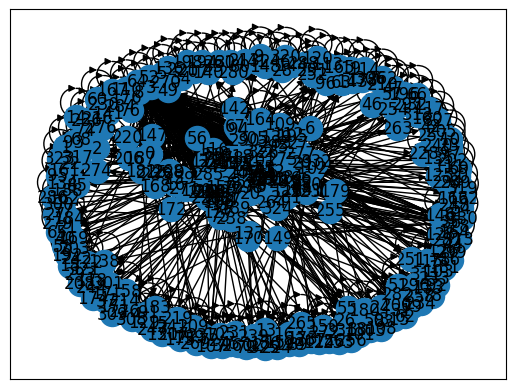

In [57]:
G=dgl.to_networkx(all_g)
ntx.draw_networkx(G)

In [58]:
all_g

Graph(num_nodes=333, num_edges=902,
      ndata_schemes={'feat': Scheme(shape=(128,), dtype=torch.float32)}
      edata_schemes={})